Dataset Basic info:

- Train images:

        - Normal Images: 1349
        - Virus images: 1345
        - Bacteria images: 2538
        - Total: 5232

- Test images:

        - Normal Images: 234 
        - Virus images: 148
        - Bacteria images: 242
        - Total: 624


In [1]:
# libraries
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers

# Chest X-Ray Pneumonia Prediction

Image size: (1858, 2090)
Image data type: uint8


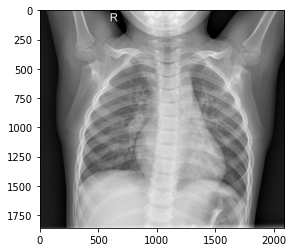

In [2]:
# Sample normal image
path = 'data/chest_pneumonia/train/normal'
img = cv2.imread(path + '/IM-0115-0001.jpeg', 0) # 1 = color, 0 = gray, -1 = unchanged
plt.imshow(img, cmap='gray')
# Basic info of the image
print('Image size:', img.shape)
print('Image data type:', img.dtype)

In [3]:
# Loading data
train_df = pd.read_csv('training_data.csv')
train_df.head()

,path,shape,rows,columns,label
0,data/chest_pneumonia/train/normal/NORMAL2-IM-0...,"(2234, 2359)",2234,2359,Healthy
1,data/chest_pneumonia/train/normal/NORMAL2-IM-1...,"(1067, 1422)",1067,1422,Healthy
2,data/chest_pneumonia/train/normal/IM-0427-0001...,"(1357, 1828)",1357,1828,Healthy
3,data/chest_pneumonia/train/normal/NORMAL2-IM-1...,"(1495, 1854)",1495,1854,Healthy
4,data/chest_pneumonia/train/normal/IM-0656-0001...,"(1966, 2194)",1966,2194,Healthy


In [4]:
test_df = pd.read_csv('test_data.csv')
test_df.tail()

,path,shape,rows,columns,label
619,data/chest_pneumonia/test/pneumonia/person120_...,"(688, 1024)",688,1024,Bacterial
620,data/chest_pneumonia/test/pneumonia/person171_...,"(672, 1088)",672,1088,Bacterial
621,data/chest_pneumonia/test/pneumonia/person109_...,"(808, 1256)",808,1256,Bacterial
622,data/chest_pneumonia/test/pneumonia/person83_b...,"(648, 912)",648,912,Bacterial
623,data/chest_pneumonia/test/pneumonia/person112_...,"(640, 952)",640,952,Bacterial


## Zero-padding so all images are the same size and squared

In [5]:
max_rows_train = max(train_df['rows'])
max_cols_train = max(train_df['columns'])
max_rows_test = max(test_df['rows'])
max_cols_test = max(test_df['columns'])
biggest_dim = max(max_rows_train, max_cols_train, max_rows_test, max_cols_test)

### Setting image sizes to the largest 

In [6]:
# Training images
train_imgs = np.zeros([len(train_df), biggest_dim, biggest_dim], dtype = 'uint8')
for i in range(len(train_df)):
    train_imgs[i, :train_df['rows'][i], :train_df['columns'][i]] = cv2.imread(train_df['path'][i], 0)
# Reshaping for keras input
train_imgs = train_imgs.reshape(train_imgs.shape[0], train_imgs.shape[1], train_imgs.shape[2], 1)

KeyboardInterrupt: 

In [27]:
# Test images
test_imgs = np.zeros([len(test_df), biggest_dim, biggest_dim], dtype = 'uint8')
for i in range(len(test_df)):
    test_imgs[i, :test_df['rows'][i], :test_df['columns'][i]] = cv2.imread(test_df['path'][i], 0)
    # Reshaping for keras input
test_imgs = test_imgs.reshape(test_imgs.shape[0], test_imgs.shape[1], test_imgs.shape[2], 1)

In [28]:
# Labels
le = LabelEncoder()
train_labels = np.array(train_df['label'])
test_labels = np.array(test_df['label'])
train_labels = le.fit_transform(train_labels)
test_labels = le.fit_transform (test_labels)

Now all the images are the same size and squared so the size is not affected by rotations or other image processing techniques. We can move on to data augmentation

## Image Augmentation

# Crating a Model and training

In [42]:
# Building a model
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(filters=8, 
                        kernel_size=(3, 3), 
                        input_shape=(biggest_dim, biggest_dim, 1), 
                        padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same"))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

ValueError: Input 0 of layer conv2d_1 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 2916, 2916)

In [32]:
# Compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
model.fit(train_imgs, train_labels, epochs=100)

Epoch 1/100


ValueError: in user code:

    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 2916, 2916)


In [ ]:
predictions = model.predict_classes(test_imgs)

In [ ]:
predictions_strings = le.inverse_transform(predictions)

In [ ]:
model.evaluate(test_images, test_labels)